# Fitting a Hologram

This notebook shows how to load a pre-recorded hologram of a colloidal sphere
into a Feature object and analyze it with Lorenz-Mie theory. The analysis yields
the radius of the sphere, the refractive index of the sphere, and the sphere's
three-dimensional location relative to the center of the imaging plane.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2

from pylorenzmie.analysis import Frame

## Framework for Lorenz-Mie analysis
First, we instantiate a Frame() object. By default, Frame analyzes features with 
the standard Lorenz-Mie model for hologram formation. The model includes a description of the holographic microscope that records the images we wish to analyze. In this example, we specify that the instrument illuminates the sample with blue light at a vacuum wavelength of $\lambda$ = 0.447 μm and has a system magnification of 0.048 μm/pixel. For particles dispersed in water, the refractive index of the medium is $n_m$ = 1.340 at the imaging wavelength. These calibration constants may differ for different hardware implementations.
The commercial xSight instrument, for example, uses a system magnification of 0.120 μm/pixel.

In [8]:
configuration = dict(wavelength = 0.447,    # [um]
                     magnification = 0.048, # [um/pixel]
                     n_m = 1.34, 
                     distribution = 'radial',
                     percentpix = 0.2)

frame = Frame(**configuration)

## Holographic microscopy data
Next, we load the (normalized) hologram we wish to fit. In the present example, we use OpenCV to load a pre-recorded hologram that was saved as a PNG image. We convert the image to grayscale and normalize it by the mean value. This hologram was cropped from a larger image. Since we are not interested in locating the particle within the original image, we provide the model with a standard coordinate system using the coordinates() helper function. We finally can provide the normalized image data to the Feature() object for analysis.

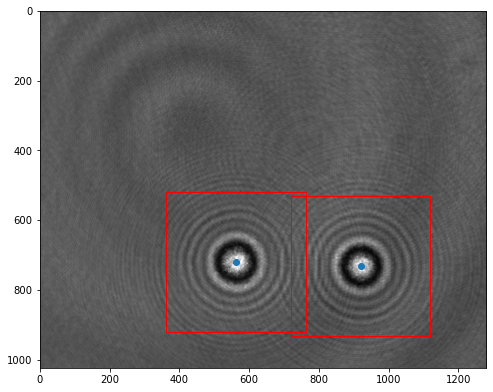

In [9]:
# Read example image
img = cv2.imread('tutorials/image0010.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img, cmap='gray')

# Background for normalization
frame.background = np.mean(img)

# Load image data
frame.image = img

# Features identified by eye
x_p = np.array([563, 920])
y_p = np.array([720, 732])

ax.scatter(x_p, y_p)

# Bounding boxes
w, h = 400, 400
x0 = (x_p - w/2).astype(int)
y0 = (y_p - h/2).astype(int)
bboxes = []
for n in range(2):
    bbox = ((x0[n], y0[n]), w, h)
    ax.add_patch(Rectangle(*bbox, fill=False, ec='r'))
    bboxes.append(bbox)
    
frame.bboxes = bboxes

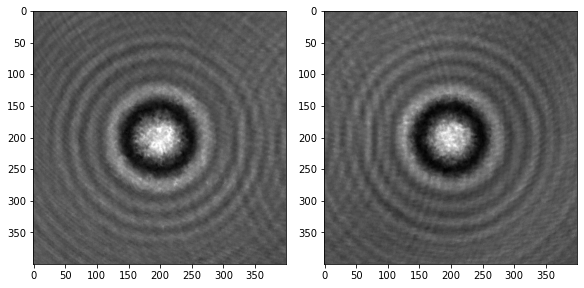

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

for ax, feature in zip(axes, frame.features):
    pixels = feature['data']
    ax.imshow(pixels, cmap='gray')

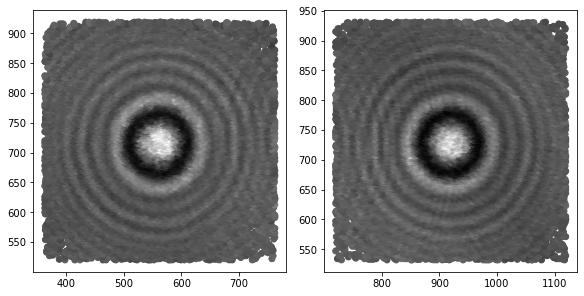

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

for ax, feature in zip(axes, frame.features):
    fitter = feature['fitter']
    fitter.data = feature['data'].ravel()
    fitter.coordinates = feature['coordinates'].reshape((2,-1))
    index = fitter.mask.selected
    coords = fitter.coordinates[:, index]
    pixels = fitter.data.ravel()[index]
    ax.scatter(coords[0,:], coords[1,:], c=pixels, cmap='gray')

In [12]:
for n, feature in enumerate(frame.features):
    particle = feature['fitter'].particle
    particle.r_p = np.array([x_p[n], y_p[n], 200])
    particle.n_p = 1.5
    particle.a_p = 1.

results = frame.optimize()

In [13]:
print(results)

          x_p      dx_p         y_p      dy_p         z_p      dz_p       a_p  \
0  562.325761  0.053512  720.611898  0.050924  175.331731  0.229843  2.089189   
1  920.263576  0.054879  732.436993  0.052477  173.761256  0.232789  2.054809   

       da_p       n_p      dn_p  success   npix    redchi  
0  0.002148  1.370023  0.000109     True  32000  9.992798  
1  0.002146  1.369375  0.000105     True  32000  9.553592  
